In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import contextlib
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")










Using device: cuda


In [2]:
# ============================================
# PREPROCESSING AND DATA LOADING
# ============================================
def load_dataset(dataset_name, data_path, subset_ratio=None):
    """
    Load and preprocess dataset with transformations
    Returns train_loader, val_loader, test_loader, and emotion labels
    """
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    
    # Load dataset based on name
    if dataset_name == "FER2013":
        train_path = os.path.join(data_path, 'train')
        test_path = os.path.join(data_path, 'test')
        
        train_dataset = ImageFolder(train_path, transform=transform)
        test_dataset = ImageFolder(test_path, transform=transform)
        
        # Get emotion labels from dataset classes
        emotion_labels = train_dataset.classes
        
        # Create subset if specified
        if subset_ratio:
            subset_len = int(len(train_dataset) * subset_ratio)
            train_dataset, _ = random_split(train_dataset, [subset_len, len(train_dataset) - subset_len])
        
        # Split train into train/validation
        val_size = int(0.1 * len(train_dataset))
        train_size = len(train_dataset) - val_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    elif dataset_name == "RAF-DB":
        train_path = os.path.join(data_path, "train")
        test_path = os.path.join(data_path, "test")
        
        train_dataset = ImageFolder(train_path, transform=transform)
        test_dataset = ImageFolder(test_path, transform=transform)
        val_dataset = test_dataset  # Use test set for validation
        
        # Manually define emotion labels for RAF-DB
        emotion_labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
    
    elif dataset_name == "CK+48":
        # CK+48 has direct emotion-named folders
        full_dataset = ImageFolder(data_path, transform=transform)
        emotion_labels = full_dataset.classes
        
        # Split 80/10/10
        train_len = int(0.8 * len(full_dataset))
        val_len = int(0.1 * len(full_dataset))
        test_len = len(full_dataset) - train_len - val_len
        
        train_dataset, val_dataset, test_dataset = random_split(
            full_dataset, [train_len, val_len, test_len]
        )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
    
    print(f"\nLoaded {dataset_name} dataset")
    print(f"Number of classes: {len(emotion_labels)}")
    print(f"Emotion labels: {emotion_labels}")
    
    return train_loader, val_loader, test_loader, emotion_labels


In [3]:
# ============================================
# MODEL CREATION
# ============================================
def create_model(model_name, num_classes):
    """Initialize pretrained model with custom classifier"""
    if model_name == "MobileNetV2":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    
    elif model_name == "ResNet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    elif model_name == "VGG19":
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(4096, num_classes)
    
    return model.to(device)


In [4]:
# ============================================
# MIXED PRECISION UTILITIES
# ============================================
def get_autocast_context():
    """Get autocast context based on device"""
    if device.type == 'cuda':
        return torch.cuda.amp.autocast
    # Create null context for CPU
    return contextlib.nullcontext

def get_grad_scaler():
    """Get appropriate GradScaler based on device"""
    if device.type == 'cuda':
        return torch.cuda.amp.GradScaler()
    # Dummy scaler for CPU
    class DummyScaler:
        def scale(self, loss): return loss
        def step(self, optimizer): optimizer.step()
        def update(self): pass
    return DummyScaler()

In [5]:
# ============================================
# TRAINING LOOP
# ============================================
def train_model(model, train_loader, val_loader, model_name, dataset_name, num_epochs=10):
    """Train model with early stopping and save best weights"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scaler = get_grad_scaler()
    autocast = get_autocast_context()
    
    # Training variables
    train_loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    patience, no_improve_count = 2, 0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss = 0.0

        # Training phase
        for images, labels in tqdm(train_loader, desc=f"[{model_name}×{dataset_name}] Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        # Calculate epoch metrics
        train_loss = total_loss / len(train_loader)
        train_loss_hist.append(train_loss)
        
        # Validation phase
        val_loss = validate_model(model, val_loader, criterion)
        val_loss_hist.append(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0
            torch.save(model.state_dict(), f"/kaggle/working/{model_name}_{dataset_name}_best.pt")
            print(f"🔥 New best model saved (val_loss={val_loss:.4f})")
        else:
            no_improve_count += 1
        
        # Epoch summary
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Time: {epoch_time:.2f}s")
        
        if no_improve_count >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}")
            break
    
    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_hist, label="Train Loss")
    plt.plot(val_loss_hist, label="Val Loss")
    plt.title(f"{model_name} × {dataset_name} - Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{model_name}_{dataset_name}_loss.png")
    plt.show()
    
    return model

def validate_model(model, val_loader, criterion):
    """Calculate validation loss"""
    model.eval()
    val_loss = 0.0
    autocast = get_autocast_context()
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
    
    return val_loss / len(val_loader)

In [6]:
# ============================================
# TESTING AND EVALUATION
# ============================================
def evaluate_model(model, test_loader, emotion_labels, model_name, dataset_name):
    """Evaluate model on test set and generate metrics"""
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=emotion_labels, 
                yticklabels=emotion_labels, 
                cmap='Blues')
    plt.title(f"{model_name} × {dataset_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{model_name}_{dataset_name}_cm.png")
    plt.show()
    
    # Classification report
    print(f"\nClassification Report for {model_name} × {dataset_name}:")
    print(classification_report(
        all_labels, all_preds, 
        target_names=emotion_labels,
        digits=4
    ))
    
    # Calculate overall accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"✅ Test Accuracy: {accuracy:.4f}")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth



Loaded FER2013 dataset
Number of classes: 7
Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

🚀 TRAINING MobileNetV2 ON FER2013 DATASET


100%|██████████| 13.6M/13.6M [00:00<00:00, 126MB/s]


Created MobileNetV2 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[MobileNetV2×FER2013] Epoch 1:   0%|          | 0/162 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=1.3846)
Epoch 1/10 | Train Loss: 1.6324 | Val Loss: 1.3846 | Time: 39.83s


[MobileNetV2×FER2013] Epoch 2:   0%|          | 0/162 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.2263)
Epoch 2/10 | Train Loss: 1.2201 | Val Loss: 1.2263 | Time: 24.45s


[MobileNetV2×FER2013] Epoch 3:   0%|          | 0/162 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.1875)
Epoch 3/10 | Train Loss: 0.9683 | Val Loss: 1.1875 | Time: 24.67s


[MobileNetV2×FER2013] Epoch 4:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.7231 | Val Loss: 1.2386 | Time: 24.36s


[MobileNetV2×FER2013] Epoch 5:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.4708 | Val Loss: 1.3868 | Time: 24.29s
🛑 Early stopping triggered at epoch 5


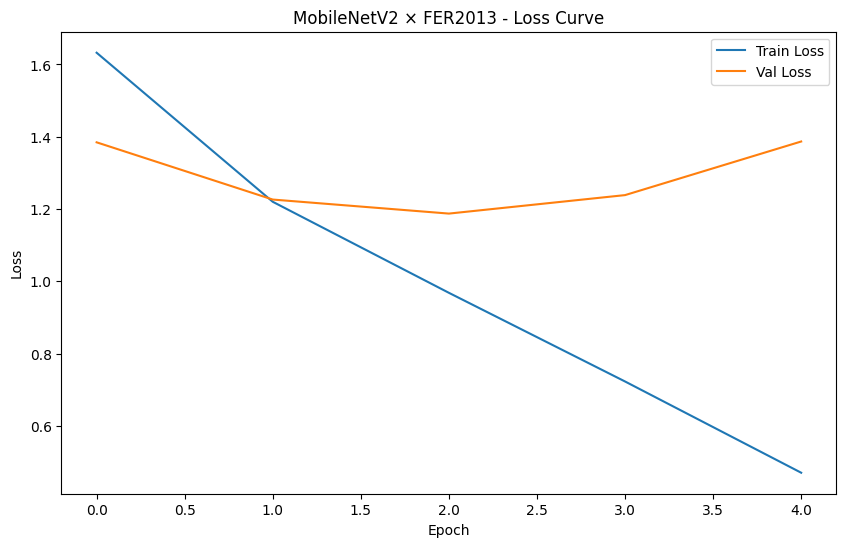

Loaded best weights for evaluation


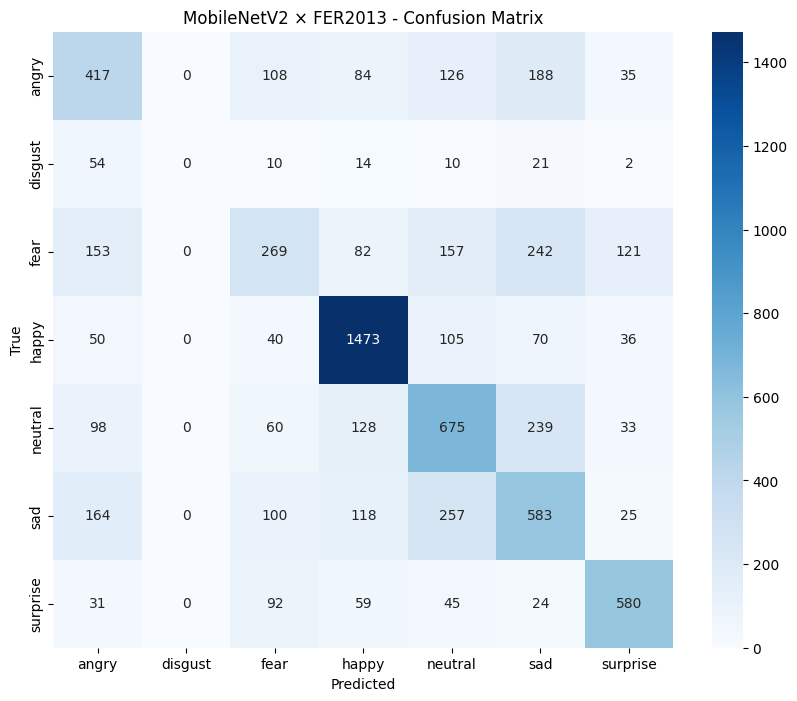


Classification Report for MobileNetV2 × FER2013:
              precision    recall  f1-score   support

       angry     0.4312    0.4353    0.4332       958
     disgust     0.0000    0.0000    0.0000       111
        fear     0.3962    0.2627    0.3159      1024
       happy     0.7523    0.8303    0.7894      1774
     neutral     0.4909    0.5474    0.5176      1233
         sad     0.4265    0.4675    0.4461      1247
    surprise     0.6971    0.6980    0.6975       831

    accuracy                         0.5568      7178
   macro avg     0.4563    0.4630    0.4571      7178
weighted avg     0.5391    0.5568    0.5451      7178

✅ Test Accuracy: 0.5568
Freed GPU memory

🚀 TRAINING ResNet50 ON FER2013 DATASET


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Downloading: "https://download.pytorch.org/models/resnet50-11ad3

Created ResNet50 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[ResNet50×FER2013] Epoch 1:   0%|          | 0/162 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=1.2841)
Epoch 1/10 | Train Loss: 1.5027 | Val Loss: 1.2841 | Time: 46.42s


[ResNet50×FER2013] Epoch 2:   0%|          | 0/162 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.1740)
Epoch 2/10 | Train Loss: 1.0177 | Val Loss: 1.1740 | Time: 46.41s


[ResNet50×FER2013] Epoch 3:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.5695 | Val Loss: 1.3373 | Time: 46.20s


[ResNet50×FER2013] Epoch 4:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.2366 | Val Loss: 1.5634 | Time: 46.08s
🛑 Early stopping triggered at epoch 4


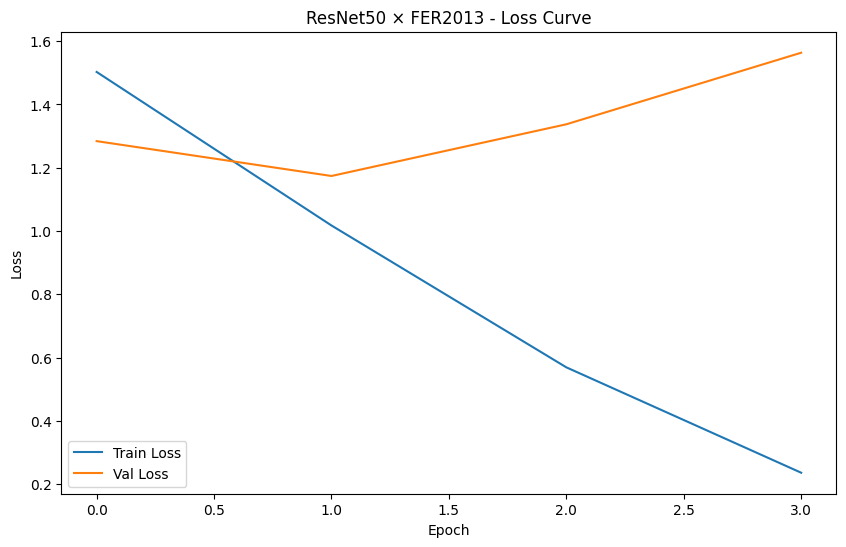

Loaded best weights for evaluation


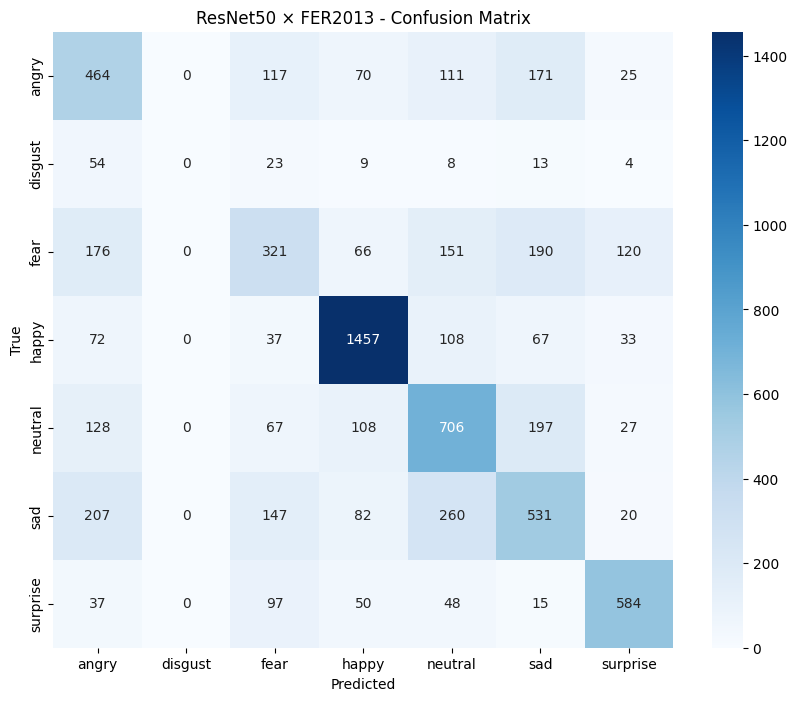


Classification Report for ResNet50 × FER2013:
              precision    recall  f1-score   support

       angry     0.4077    0.4843    0.4427       958
     disgust     0.0000    0.0000    0.0000       111
        fear     0.3968    0.3135    0.3502      1024
       happy     0.7910    0.8213    0.8059      1774
     neutral     0.5072    0.5726    0.5379      1233
         sad     0.4485    0.4258    0.4369      1247
    surprise     0.7183    0.7028    0.7105       831

    accuracy                         0.5660      7178
   macro avg     0.4671    0.4743    0.4692      7178
weighted avg     0.5547    0.5660    0.5588      7178

✅ Test Accuracy: 0.5660
Freed GPU memory

🚀 TRAINING VGG19 ON FER2013 DATASET


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d

Created VGG19 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[VGG19×FER2013] Epoch 1:   0%|          | 0/162 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=1.2300)
Epoch 1/10 | Train Loss: 1.4579 | Val Loss: 1.2300 | Time: 90.79s


[VGG19×FER2013] Epoch 2:   0%|          | 0/162 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.1633)
Epoch 2/10 | Train Loss: 1.1403 | Val Loss: 1.1633 | Time: 91.23s


[VGG19×FER2013] Epoch 3:   0%|          | 0/162 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.1066)
Epoch 3/10 | Train Loss: 0.9603 | Val Loss: 1.1066 | Time: 91.26s


[VGG19×FER2013] Epoch 4:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.7728 | Val Loss: 1.1804 | Time: 89.65s


[VGG19×FER2013] Epoch 5:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.5808 | Val Loss: 1.3235 | Time: 89.68s
🛑 Early stopping triggered at epoch 5


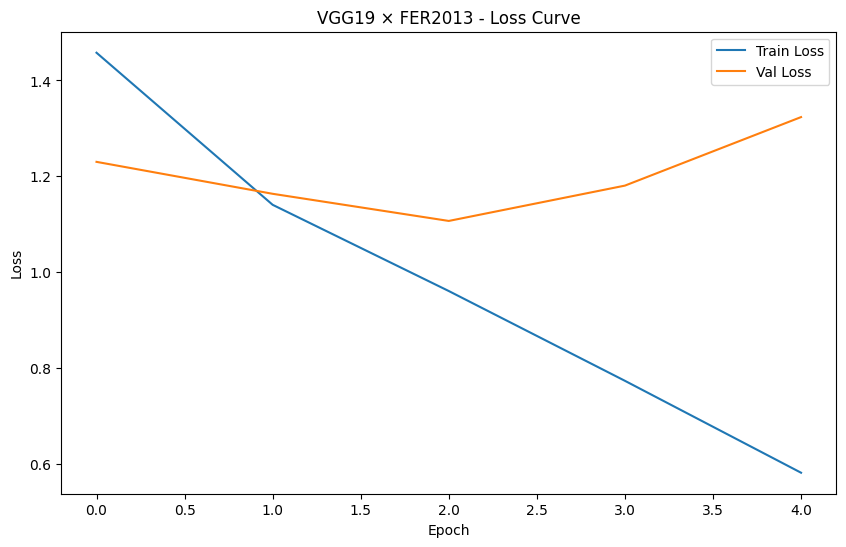

Loaded best weights for evaluation


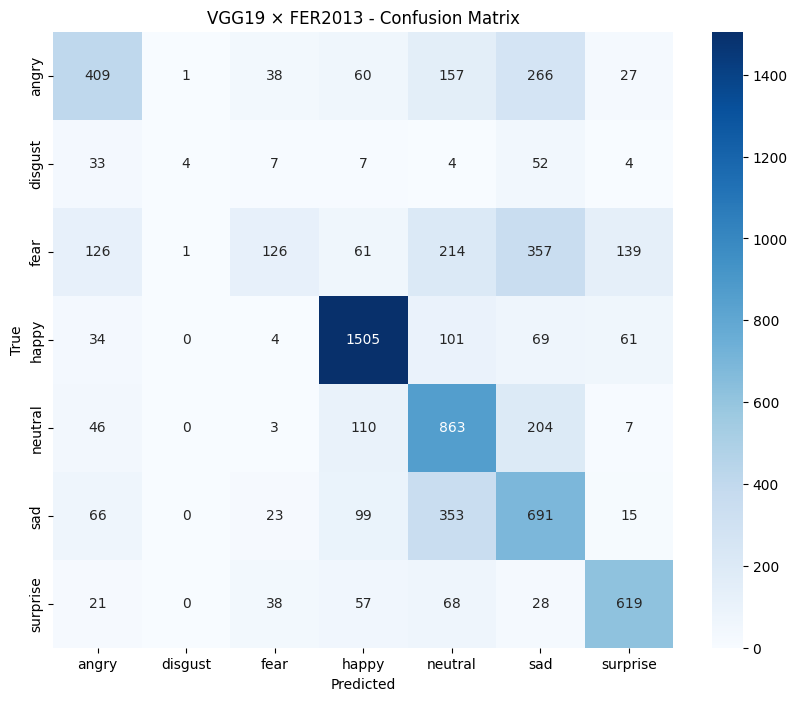


Classification Report for VGG19 × FER2013:
              precision    recall  f1-score   support

       angry     0.5565    0.4269    0.4832       958
     disgust     0.6667    0.0360    0.0684       111
        fear     0.5272    0.1230    0.1995      1024
       happy     0.7925    0.8484    0.8195      1774
     neutral     0.4903    0.6999    0.5767      1233
         sad     0.4145    0.5541    0.4743      1247
    surprise     0.7099    0.7449    0.7270       831

    accuracy                         0.5875      7178
   macro avg     0.5939    0.4905    0.4784      7178
weighted avg     0.5941    0.5875    0.5621      7178

✅ Test Accuracy: 0.5875
Freed GPU memory

Loaded RAF-DB dataset
Number of classes: 7
Emotion labels: ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']

🚀 TRAINING MobileNetV2 ON RAF-DB DATASET
Created MobileNetV2 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[MobileNetV2×RAF-DB] Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=1.0708)
Epoch 1/10 | Train Loss: 1.3877 | Val Loss: 1.0708 | Time: 46.05s


[MobileNetV2×RAF-DB] Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.8293)
Epoch 2/10 | Train Loss: 0.8997 | Val Loss: 0.8293 | Time: 31.78s


[MobileNetV2×RAF-DB] Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.7358)
Epoch 3/10 | Train Loss: 0.6274 | Val Loss: 0.7358 | Time: 31.66s


[MobileNetV2×RAF-DB] Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.4196 | Val Loss: 0.7391 | Time: 31.76s


[MobileNetV2×RAF-DB] Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.2555 | Val Loss: 0.7998 | Time: 31.56s
🛑 Early stopping triggered at epoch 5


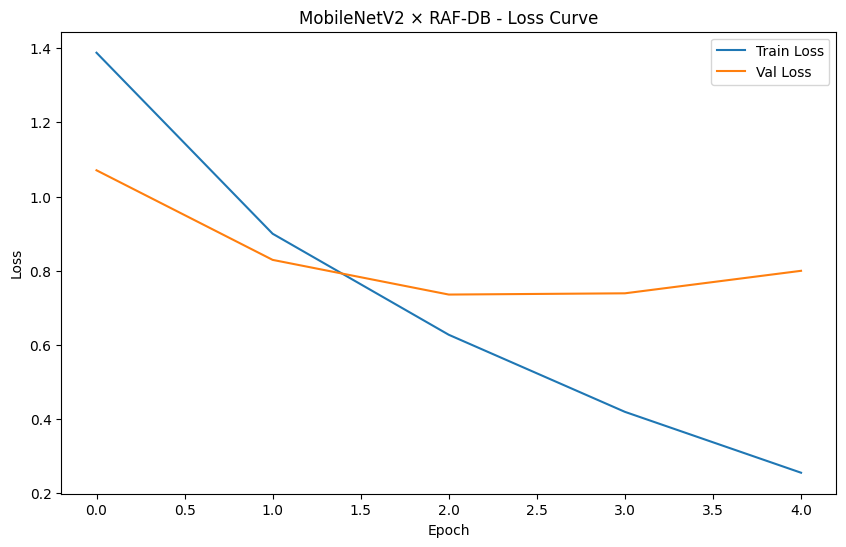

Loaded best weights for evaluation


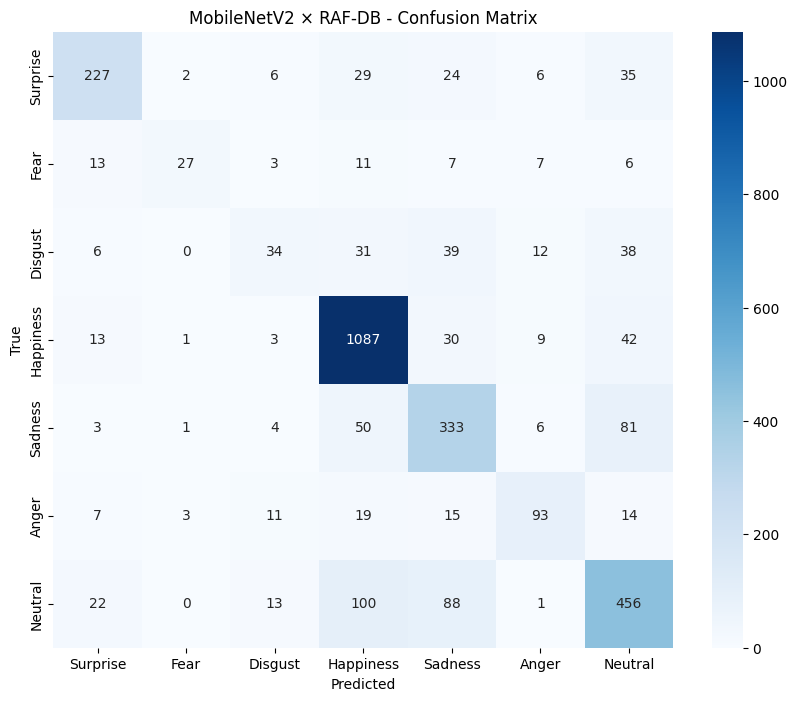


Classification Report for MobileNetV2 × RAF-DB:
              precision    recall  f1-score   support

    Surprise     0.7801    0.6900    0.7323       329
        Fear     0.7941    0.3649    0.5000        74
     Disgust     0.4595    0.2125    0.2906       160
   Happiness     0.8191    0.9173    0.8654      1185
     Sadness     0.6213    0.6967    0.6568       478
       Anger     0.6940    0.5741    0.6284       162
     Neutral     0.6786    0.6706    0.6746       680

    accuracy                         0.7357      3068
   macro avg     0.6924    0.5894    0.6211      3068
weighted avg     0.7270    0.7357    0.7250      3068

✅ Test Accuracy: 0.7357
Freed GPU memory

🚀 TRAINING ResNet50 ON RAF-DB DATASET
Created ResNet50 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[ResNet50×RAF-DB] Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=0.8211)
Epoch 1/10 | Train Loss: 1.2153 | Val Loss: 0.8211 | Time: 57.67s


[ResNet50×RAF-DB] Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.6678)
Epoch 2/10 | Train Loss: 0.6168 | Val Loss: 0.6678 | Time: 57.84s


[ResNet50×RAF-DB] Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.2593 | Val Loss: 0.7561 | Time: 57.82s


[ResNet50×RAF-DB] Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.0960 | Val Loss: 0.7988 | Time: 57.65s
🛑 Early stopping triggered at epoch 4


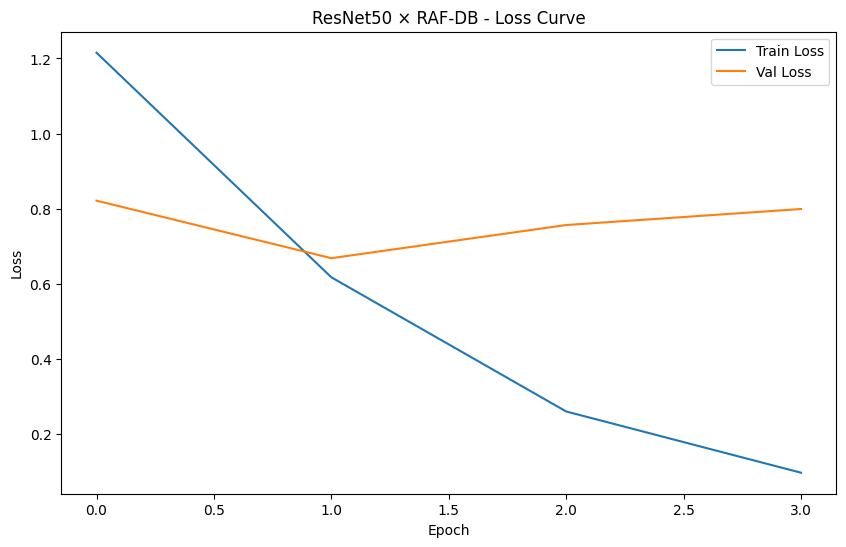

Loaded best weights for evaluation


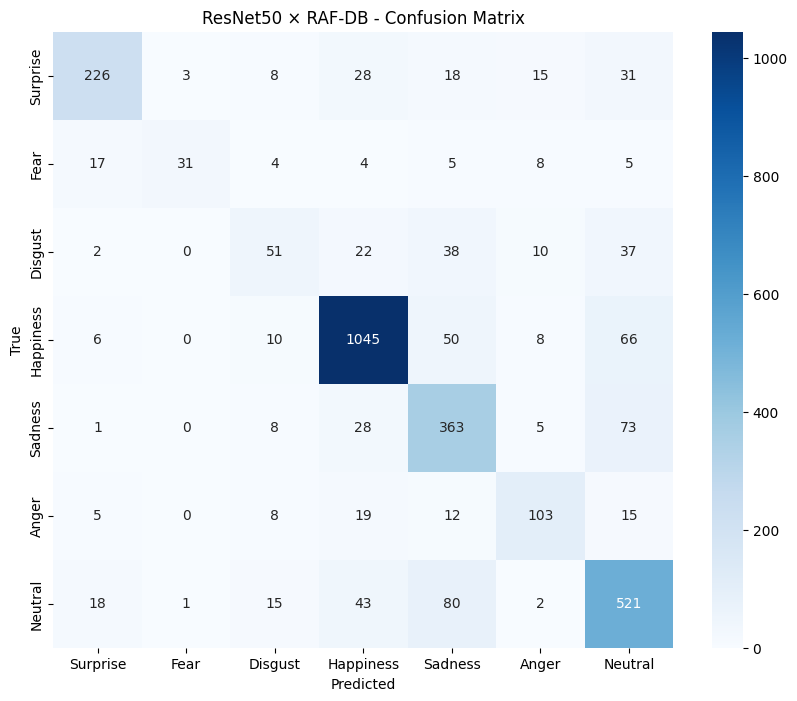


Classification Report for ResNet50 × RAF-DB:
              precision    recall  f1-score   support

    Surprise     0.8218    0.6869    0.7483       329
        Fear     0.8857    0.4189    0.5688        74
     Disgust     0.4904    0.3187    0.3864       160
   Happiness     0.8789    0.8819    0.8804      1185
     Sadness     0.6413    0.7594    0.6954       478
       Anger     0.6821    0.6358    0.6581       162
     Neutral     0.6965    0.7662    0.7297       680

    accuracy                         0.7627      3068
   macro avg     0.7281    0.6383    0.6667      3068
weighted avg     0.7649    0.7627    0.7590      3068

✅ Test Accuracy: 0.7627
Freed GPU memory

🚀 TRAINING VGG19 ON RAF-DB DATASET
Created VGG19 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[VGG19×RAF-DB] Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=0.7525)
Epoch 1/10 | Train Loss: 1.0499 | Val Loss: 0.7525 | Time: 112.08s


[VGG19×RAF-DB] Epoch 2:   0%|          | 0/192 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.6653)
Epoch 2/10 | Train Loss: 0.6537 | Val Loss: 0.6653 | Time: 112.65s


[VGG19×RAF-DB] Epoch 3:   0%|          | 0/192 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.5655)
Epoch 3/10 | Train Loss: 0.4817 | Val Loss: 0.5655 | Time: 112.53s


[VGG19×RAF-DB] Epoch 4:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.3204 | Val Loss: 0.5971 | Time: 110.97s


[VGG19×RAF-DB] Epoch 5:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.2193 | Val Loss: 0.6062 | Time: 110.98s
🛑 Early stopping triggered at epoch 5


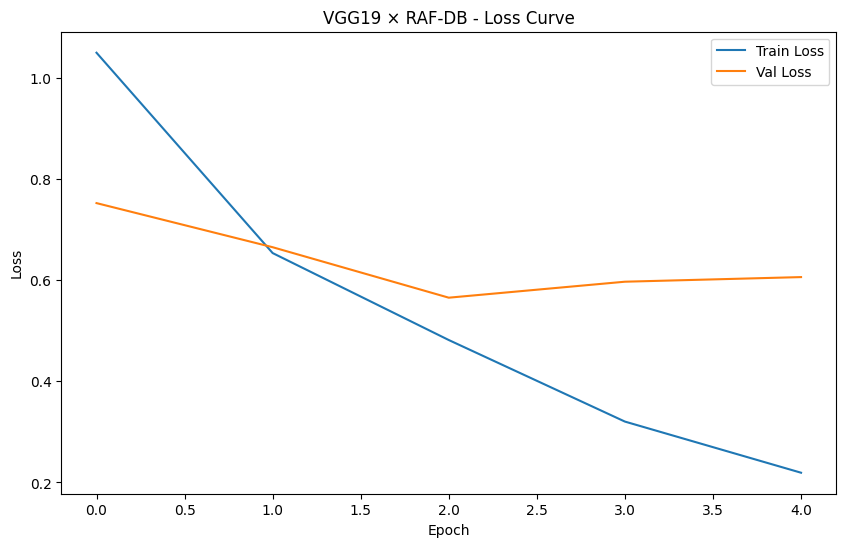

Loaded best weights for evaluation


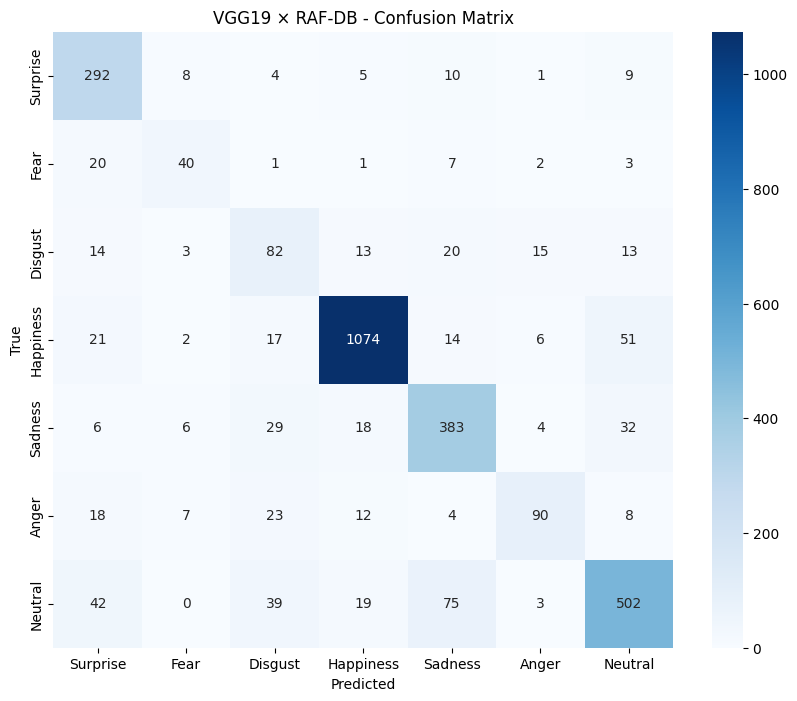


Classification Report for VGG19 × RAF-DB:
              precision    recall  f1-score   support

    Surprise     0.7070    0.8875    0.7871       329
        Fear     0.6061    0.5405    0.5714        74
     Disgust     0.4205    0.5125    0.4620       160
   Happiness     0.9405    0.9063    0.9231      1185
     Sadness     0.7466    0.8013    0.7730       478
       Anger     0.7438    0.5556    0.6360       162
     Neutral     0.8123    0.7382    0.7735       680

    accuracy                         0.8028      3068
   macro avg     0.7110    0.7060    0.7037      3068
weighted avg     0.8112    0.8028    0.8043      3068

✅ Test Accuracy: 0.8028
Freed GPU memory

Loaded CK+48 dataset
Number of classes: 7
Emotion labels: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

🚀 TRAINING MobileNetV2 ON CK+48 DATASET
Created MobileNetV2 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[MobileNetV2×CK+48] Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=1.9027)
Epoch 1/10 | Train Loss: 1.8383 | Val Loss: 1.9027 | Time: 3.21s


/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[MobileNetV2×CK+48] Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.7908)
Epoch 2/10 | Train Loss: 1.5011 | Val Loss: 1.7908 | Time: 2.48s


[MobileNetV2×CK+48] Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.6043)
Epoch 3/10 | Train Loss: 1.1574 | Val Loss: 1.6043 | Time: 2.48s


[MobileNetV2×CK+48] Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.4721)
Epoch 4/10 | Train Loss: 0.8613 | Val Loss: 1.4721 | Time: 2.51s


[MobileNetV2×CK+48] Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.1705)
Epoch 5/10 | Train Loss: 0.6436 | Val Loss: 1.1705 | Time: 2.54s


[MobileNetV2×CK+48] Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.8589)
Epoch 6/10 | Train Loss: 0.4962 | Val Loss: 0.8589 | Time: 2.52s


[MobileNetV2×CK+48] Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.6387)
Epoch 7/10 | Train Loss: 0.3908 | Val Loss: 0.6387 | Time: 2.50s


[MobileNetV2×CK+48] Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.4734)
Epoch 8/10 | Train Loss: 0.2685 | Val Loss: 0.4734 | Time: 2.51s


[MobileNetV2×CK+48] Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.3722)
Epoch 9/10 | Train Loss: 0.1930 | Val Loss: 0.3722 | Time: 2.59s


[MobileNetV2×CK+48] Epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.2899)
Epoch 10/10 | Train Loss: 0.1203 | Val Loss: 0.2899 | Time: 2.57s


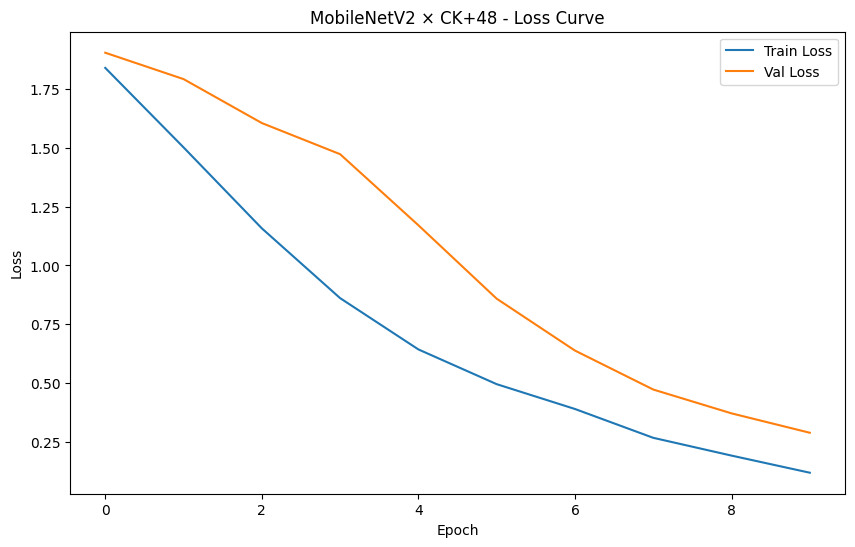

Loaded best weights for evaluation


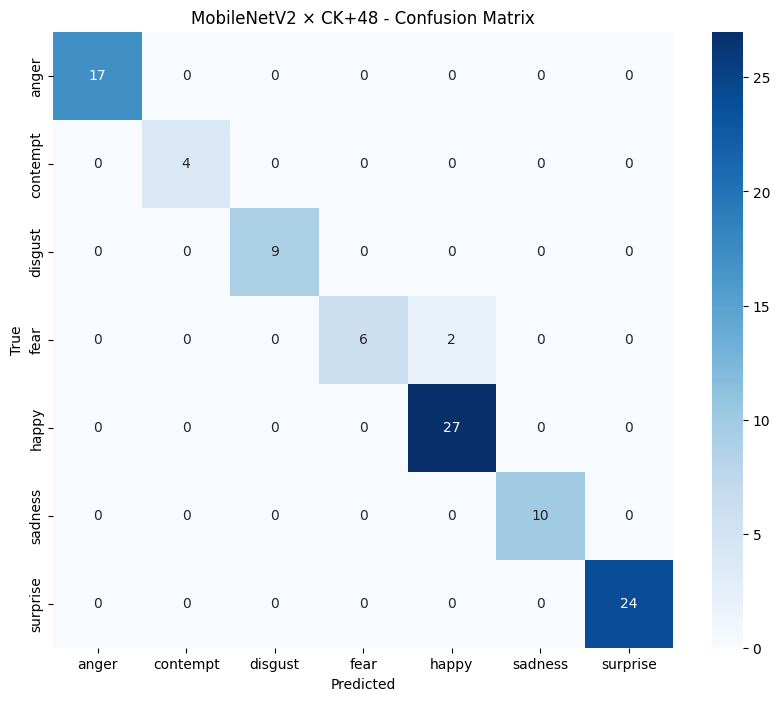


Classification Report for MobileNetV2 × CK+48:
              precision    recall  f1-score   support

       anger     1.0000    1.0000    1.0000        17
    contempt     1.0000    1.0000    1.0000         4
     disgust     1.0000    1.0000    1.0000         9
        fear     1.0000    0.7500    0.8571         8
       happy     0.9310    1.0000    0.9643        27
     sadness     1.0000    1.0000    1.0000        10
    surprise     1.0000    1.0000    1.0000        24

    accuracy                         0.9798        99
   macro avg     0.9901    0.9643    0.9745        99
weighted avg     0.9812    0.9798    0.9787        99

✅ Test Accuracy: 0.9798
Freed GPU memory

🚀 TRAINING ResNet50 ON CK+48 DATASET
Created ResNet50 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[ResNet50×CK+48] Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=1.8823)
Epoch 1/10 | Train Loss: 1.8263 | Val Loss: 1.8823 | Time: 4.35s


[ResNet50×CK+48] Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.7204)
Epoch 2/10 | Train Loss: 1.2658 | Val Loss: 1.7204 | Time: 4.44s


[ResNet50×CK+48] Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.4687)
Epoch 3/10 | Train Loss: 0.7361 | Val Loss: 1.4687 | Time: 4.48s


[ResNet50×CK+48] Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=1.1033)
Epoch 4/10 | Train Loss: 0.3875 | Val Loss: 1.1033 | Time: 4.47s


[ResNet50×CK+48] Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.6699)
Epoch 5/10 | Train Loss: 0.1744 | Val Loss: 0.6699 | Time: 4.42s


[ResNet50×CK+48] Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.3254)
Epoch 6/10 | Train Loss: 0.0482 | Val Loss: 0.3254 | Time: 4.45s


[ResNet50×CK+48] Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.1364)
Epoch 7/10 | Train Loss: 0.0151 | Val Loss: 0.1364 | Time: 4.47s


[ResNet50×CK+48] Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.1300)
Epoch 8/10 | Train Loss: 0.0077 | Val Loss: 0.1300 | Time: 4.44s


[ResNet50×CK+48] Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.1069)
Epoch 9/10 | Train Loss: 0.0046 | Val Loss: 0.1069 | Time: 4.43s


[ResNet50×CK+48] Epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.1019)
Epoch 10/10 | Train Loss: 0.0029 | Val Loss: 0.1019 | Time: 4.45s


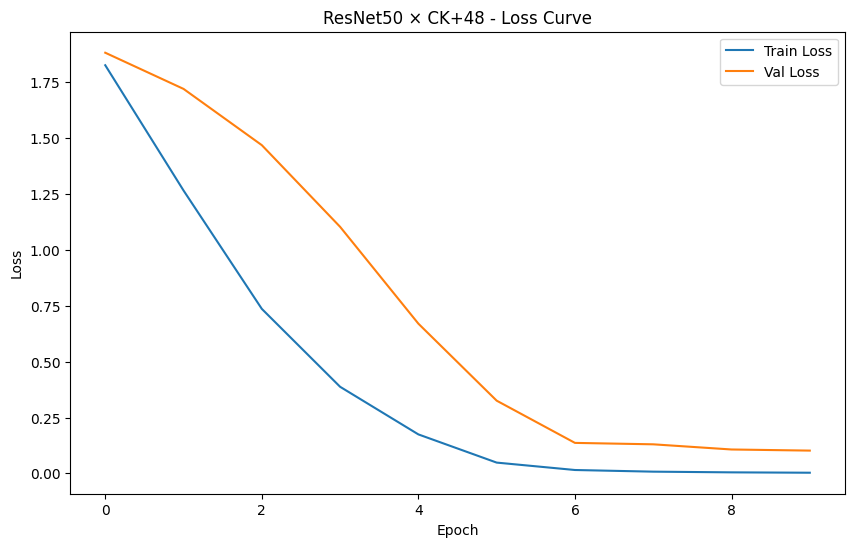

Loaded best weights for evaluation


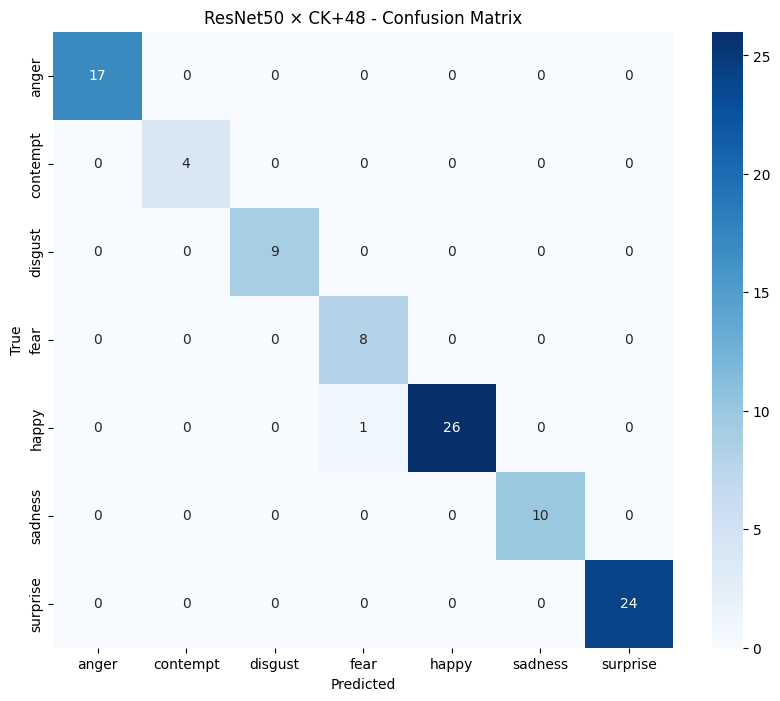


Classification Report for ResNet50 × CK+48:
              precision    recall  f1-score   support

       anger     1.0000    1.0000    1.0000        17
    contempt     1.0000    1.0000    1.0000         4
     disgust     1.0000    1.0000    1.0000         9
        fear     0.8889    1.0000    0.9412         8
       happy     1.0000    0.9630    0.9811        27
     sadness     1.0000    1.0000    1.0000        10
    surprise     1.0000    1.0000    1.0000        24

    accuracy                         0.9899        99
   macro avg     0.9841    0.9947    0.9889        99
weighted avg     0.9910    0.9899    0.9901        99

✅ Test Accuracy: 0.9899
Freed GPU memory

🚀 TRAINING VGG19 ON CK+48 DATASET
Created VGG19 model with 7 output classes


/tmp/ipykernel_19/2230808380.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


[VGG19×CK+48] Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_19/13289816.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_19/13289816.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔥 New best model saved (val_loss=0.9452)
Epoch 1/10 | Train Loss: 1.4547 | Val Loss: 0.9452 | Time: 8.67s


[VGG19×CK+48] Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.3469)
Epoch 2/10 | Train Loss: 0.6150 | Val Loss: 0.3469 | Time: 9.19s


[VGG19×CK+48] Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.3067 | Val Loss: 0.4659 | Time: 7.60s


[VGG19×CK+48] Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.3030)
Epoch 4/10 | Train Loss: 0.2328 | Val Loss: 0.3030 | Time: 9.19s


[VGG19×CK+48] Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.0785 | Val Loss: 0.4384 | Time: 7.62s


[VGG19×CK+48] Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.1263)
Epoch 6/10 | Train Loss: 0.1335 | Val Loss: 0.1263 | Time: 9.14s


[VGG19×CK+48] Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.0409)
Epoch 7/10 | Train Loss: 0.0452 | Val Loss: 0.0409 | Time: 9.24s


[VGG19×CK+48] Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0484 | Val Loss: 0.0453 | Time: 7.60s


[VGG19×CK+48] Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.0128)
Epoch 9/10 | Train Loss: 0.0159 | Val Loss: 0.0128 | Time: 9.18s


[VGG19×CK+48] Epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

🔥 New best model saved (val_loss=0.0105)
Epoch 10/10 | Train Loss: 0.0235 | Val Loss: 0.0105 | Time: 9.22s


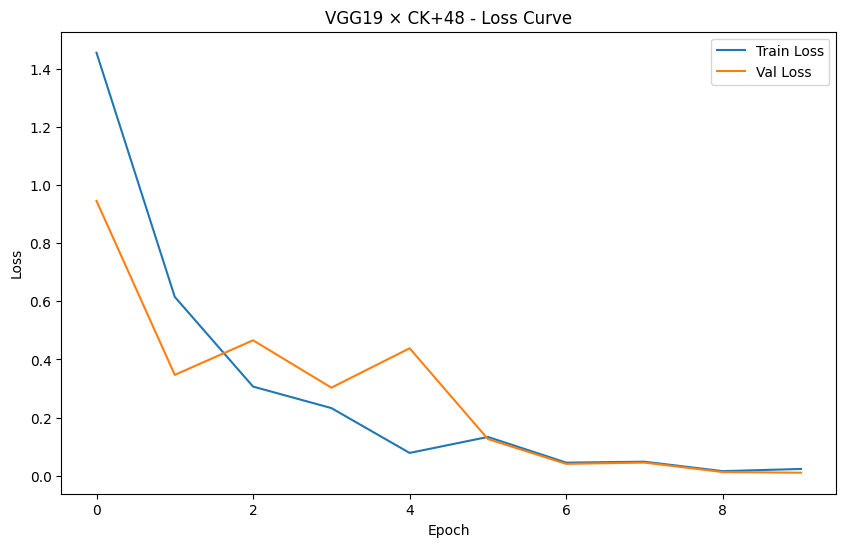

Loaded best weights for evaluation


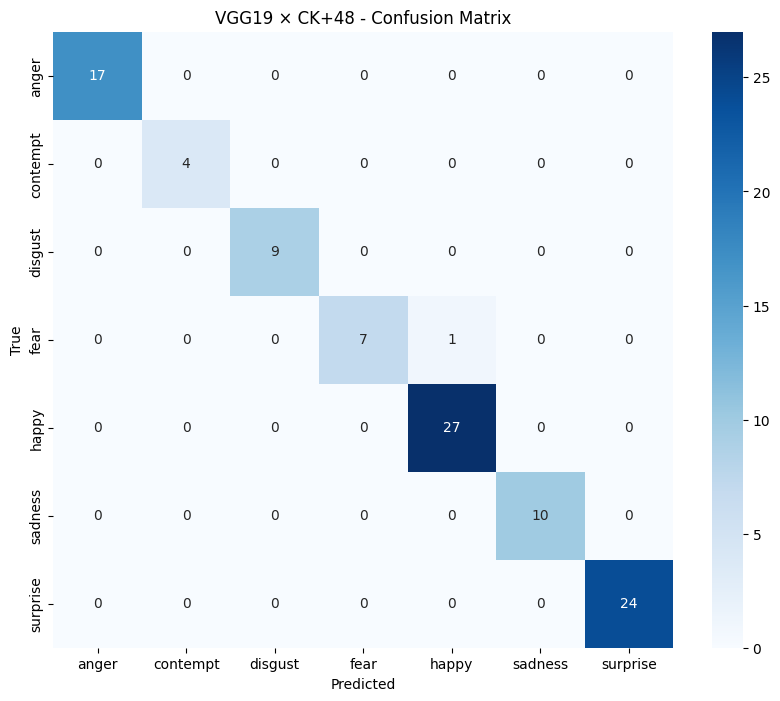


Classification Report for VGG19 × CK+48:
              precision    recall  f1-score   support

       anger     1.0000    1.0000    1.0000        17
    contempt     1.0000    1.0000    1.0000         4
     disgust     1.0000    1.0000    1.0000         9
        fear     1.0000    0.8750    0.9333         8
       happy     0.9643    1.0000    0.9818        27
     sadness     1.0000    1.0000    1.0000        10
    surprise     1.0000    1.0000    1.0000        24

    accuracy                         0.9899        99
   macro avg     0.9949    0.9821    0.9879        99
weighted avg     0.9903    0.9899    0.9897        99

✅ Test Accuracy: 0.9899
Freed GPU memory


In [7]:
# ============================================
# MAIN EXECUTION FLOW
# ============================================
if __name__ == "__main__":
    # Configuration dictionary {dataset: (path, subset_ratio)}
    datasets_config = {
        "FER2013": ("/kaggle/input/fer2013", 0.4),  # 40% subset for quick training
        "RAF-DB": ("/kaggle/input/raf-db-dataset/DATASET", None),
        "CK+48": ("/kaggle/input/ckplus/CK+48", None)
    }
    
    models_to_run = ["MobileNetV2", "ResNet50", "VGG19"]
    
    for dataset_name, (data_path, subset_ratio) in datasets_config.items():
        # Load dataset
        train_loader, val_loader, test_loader, emotion_labels = load_dataset(
            dataset_name, data_path, subset_ratio
        )
        
        for model_name in models_to_run:
            print(f"\n{'='*70}")
            print(f"🚀 TRAINING {model_name} ON {dataset_name} DATASET")
            print(f"{'='*70}")
            
            # Create model
            model = create_model(model_name, len(emotion_labels))
            print(f"Created {model_name} model with {len(emotion_labels)} output classes")
            
            # Train model
            trained_model = train_model(
                model, train_loader, val_loader,
                model_name, dataset_name, num_epochs=10
            )
            
            # Load best weights
            trained_model.load_state_dict(torch.load(f"/kaggle/working/{model_name}_{dataset_name}_best.pt"))
            print(f"Loaded best weights for evaluation")
            
            # Evaluate
            evaluate_model(
                trained_model, test_loader,
                emotion_labels, model_name, dataset_name
            )
            
            # Clear memory
            del trained_model
            torch.cuda.empty_cache()
            print(f"Freed GPU memory")

In [8]:
import os
import zipfile
from IPython.display import FileLink

def create_output_zip():
    """Create a zip file of all files in Kaggle working directory"""
    output_dir = "/kaggle/working/"
    zip_path = "/kaggle/working/output_files.zip"
    
    # Create zip file
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                # Skip the zip file itself if it exists
                if file == "output_files.zip":
                    continue
                file_path = os.path.join(root, file)
                # Add file to zip with relative path
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)
    
    # Create download link
    return FileLink(zip_path)

# Create and provide download link
print("📦 Creating zip file of all output files...")
download_link = create_output_zip()
print("✅ Download ready! Click the link below to download:")
download_link

📦 Creating zip file of all output files...
✅ Download ready! Click the link below to download:


/kaggle/working/output_files.zip